# Data preparation

In [1]:
import infrastructure.creodias
import geopandas
import subprocess
import rasterio
import rasterio.windows
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import h5py
import os
from tqdm import tqdm

In [2]:
api = infrastructure.creodias.ODataAPI()

data_folder = os.path.join("/home", "eouser", "data", "glaciermapping")

## New Zealand example

In [3]:
aoi_path = os.path.join(data_folder, "vector", "NZ1", "aoi.shp")
aoi = geopandas.read_file(aoi_path)
geometry = aoi.iloc[0].geometry

### Optical data preparation

In [4]:
sentinel2_scenes = api.search(
    "S2", "L1C", 
    start_date="2019-02-01", 
    end_date="2019-03-31", 
    geometry=geometry, 
    max_cloud_cover=3,
    expand=True
)

In [5]:
sentinel2_paths = [_["S3Path"] for _ in sentinel2_scenes["value"]]
sentinel2_paths

['/eodata/Sentinel-2/MSI/L1C/2019/02/01/S2B_MSIL1C_20190201T223659_N0207_R072_T59GLN_20190201T233945.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/01/S2B_MSIL1C_20190201T223659_N0207_R072_T59GNN_20190201T233945.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/01/S2B_MSIL1C_20190201T223659_N0207_R072_T59GLM_20190201T233945.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/01/S2B_MSIL1C_20190201T223659_N0207_R072_T59GMN_20190201T233945.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/01/S2B_MSIL1C_20190201T223659_N0207_R072_T59GMM_20190201T233945.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/03/S2A_MSIL1C_20190203T222531_N0207_R029_T59GMM_20190203T232215.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/03/S2A_MSIL1C_20190203T222531_N0207_R029_T59GNM_20190203T232215.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/24/S2B_MSIL1C_20190224T224359_N0207_R115_T59GLN_20190224T235143.SAFE',
 '/eodata/Sentinel-2/MSI/L1C/2019/02/28/S2B_MSIL1C_20190228T222539_N0207_R029_T59GMN_20190228T233503.SAFE',
 '/eodata/Sentinel-2/MSI/L1C

In [ ]:
for path in sentinel2_paths:
    filename = path.split(os.sep)[-1]
    filename = ''.join(filename.split('.')[:-1])
    output_path = os.path.join(data_folder, "raster", "NZ1", "sentinel2", f"{filename}.tif")
    subprocess.run(f"""
        bash -c '
        source ~/anaconda3/bin/activate;
        conda activate snap;
        python utils/geo/preprocess_s2.py {path} {aoi_path} {output_path}
        '
    """, shell=True)

In [6]:
sentinel2_glob = os.path.join(data_folder, "raster", "NZ1", "sentinel2", "S2*.tif")
sentinel2_mosaic_path = os.path.join(data_folder, "raster", "NZ1", "sentinel2", "mosaic.tif")

In [ ]:
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/mosaic.py {sentinel2_mosaic_path} {sentinel2_glob} --nodata 0;
    python utils/geo/s2_dn_to_toa.py {sentinel2_mosaic_path}
    '
""", shell=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/eouser/anaconda3/envs/tfgeo/lib/python3.10/site-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


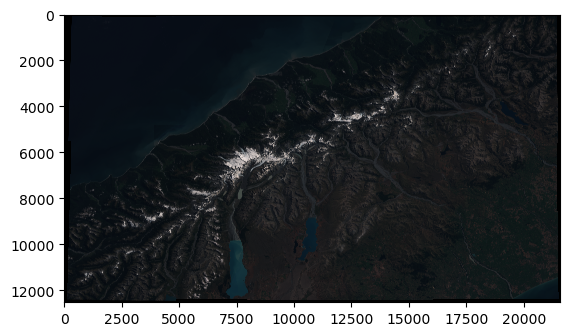

In [7]:
with rasterio.open(sentinel2_mosaic_path, "r") as src:
    blue, green, red = src.read(1), src.read(2), src.read(3)
    plt.imshow(np.stack([red, green, blue], axis=-1))

### SAR data preparation

In [8]:
sentinel1_scenes = api.search(
    "S1", "GRD", "IW", "SDV",
    start_date="2019-03-20", 
    end_date="2019-03-31", 
    geometry=geometry, 
    expand=True
)

In [9]:
sentinel1_asc_paths = [
    item["S3Path"] for item in sentinel1_scenes["value"] 
    if any([attr["Name"] == "orbitDirection" and attr["Value"] == "ASCENDING" for attr in item["Attributes"]])
]
sentinel1_desc_paths = [
    item["S3Path"] for item in sentinel1_scenes["value"] 
    if any([attr["Name"] == "orbitDirection" and attr["Value"] == "DESCENDING" for attr in item["Attributes"]])
]
sentinel1_asc_paths, sentinel1_desc_paths

(['/eodata/Sentinel-1/SAR/GRD/2019/03/21/S1B_IW_GRDH_1SDV_20190321T073759_20190321T073828_015449_01CEF7_5BE6.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/23/S1B_IW_GRDH_1SDV_20190323T072147_20190323T072216_015478_01CFE9_7AFA.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/26/S1B_IW_GRDH_1SDV_20190326T074603_20190326T074631_015522_01D176_D2D8.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/28/S1B_IW_GRDH_1SDV_20190328T072943_20190328T073012_015551_01D263_DC17.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/28/S1B_IW_GRDH_1SDV_20190328T073012_20190328T073040_015551_01D263_26EB.SAFE'],
 ['/eodata/Sentinel-1/SAR/GRD/2019/03/23/S1A_IW_GRDH_1SDV_20190323T173928_20190323T173953_026468_02F6CA_3D59.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/23/S1A_IW_GRDH_1SDV_20190323T173953_20190323T174018_026468_02F6CA_0B54.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/28/S1A_IW_GRDH_1SDV_20190328T174747_20190328T174816_026541_02F972_D718.SAFE',
  '/eodata/Sentinel-1/SAR/GRD/2019/03/30/S1A_IW_GRDH_1SDV_20190330T1731

In [ ]:
for path in sentinel1_asc_paths:
    filename = path.split(os.sep)[-1]
    filename = ''.join(filename.split('.')[:-1])
    output_path = os.path.join(data_folder, "raster", "NZ1", "sentinel1", "asc", f"{filename}.tif")
    subprocess.run(f"""
        bash -c '
        source ~/anaconda3/bin/activate;
        conda activate snap;
        python utils/geo/preprocess_s1.py {path} {aoi_path} {output_path}
        '
    """, shell=True)

In [ ]:
for path in sentinel1_desc_paths:
    filename = path.split(os.sep)[-1]
    filename = ''.join(filename.split('.')[:-1])
    output_path = os.path.join(data_folder, "raster", "NZ1", "sentinel1", "desc", f"{filename}.tif")
    subprocess.run(f"""
        bash -c '
        source ~/anaconda3/bin/activate;
        conda activate snap;
        python utils/geo/preprocess_s1.py {path} {aoi_path} {output_path}
        '
    """, shell=True)

In [10]:
sentinel1_asc_glob = os.path.join(data_folder, "raster", "NZ1", "sentinel1", "asc", "S1*.tif")
sentinel1_asc_mosaic_path = os.path.join(data_folder, "raster", "NZ1", "sentinel1", "asc", "mosaic.tif")

In [ ]:
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/mosaic.py {sentinel1_asc_mosaic_path} {sentinel1_asc_glob} --nodata 0;
    python utils/geo/s1_to_db.py {sentinel1_asc_mosaic_path}
    '
""", shell=True)

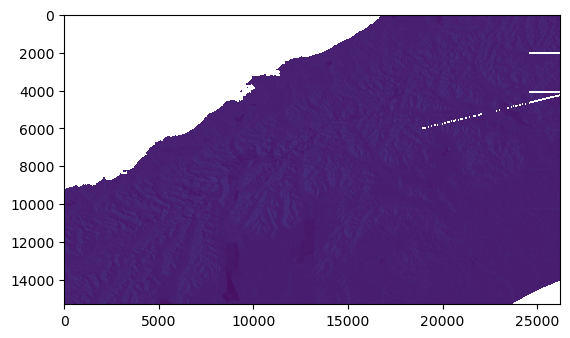

In [11]:
with rasterio.open(sentinel1_asc_mosaic_path, "r") as src:
    array = src.read()[0, ...]
    plt.imshow(array)

In [12]:
sentinel1_desc_glob = os.path.join(data_folder, "raster", "NZ1", "sentinel1", "desc", "S1*.tif")
sentinel1_desc_mosaic_path = os.path.join(data_folder, "raster", "NZ1", "sentinel1", "desc", "mosaic.tif")

In [ ]:
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/mosaic.py {sentinel1_desc_mosaic_path} {sentinel1_desc_glob} --nodata 0;
    python utils/geo/s1_to_db.py {sentinel1_desc_mosaic_path}
    '
""", shell=True)

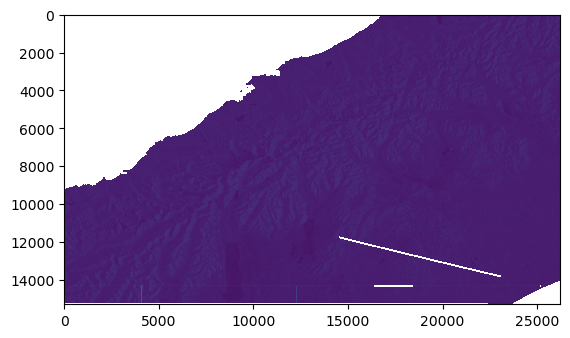

In [13]:
with rasterio.open(sentinel1_desc_mosaic_path, "r") as src:
    array = src.read()[0, ...]
    plt.imshow(array)

### DEM preparation

In [14]:
dem_glob = os.path.join(data_folder, "raster", "NZ1", "dem", "ALPSMLC30*DSM.tif")
dem_mosaic_path = os.path.join(data_folder, "raster", "NZ1", "dem", "elevation.tif")
slope_path = os.path.join(data_folder, "raster", "NZ1", "dem", "slope.tif")

In [ ]:
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/merge.py {dem_mosaic_path} {dem_glob};
    python utils/geo/slope.py {dem_mosaic_path} {slope_path}
    '
""", shell=True)

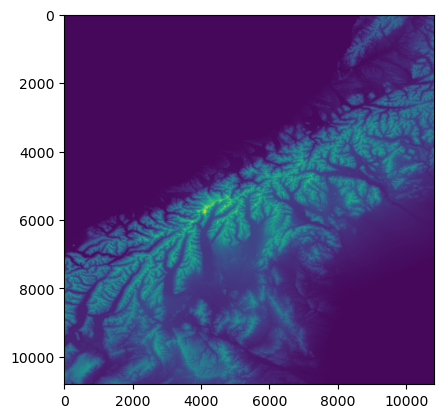

In [15]:
with rasterio.open(dem_mosaic_path, "r") as src:
    array = src.read()[0, ...]
    plt.imshow(array)

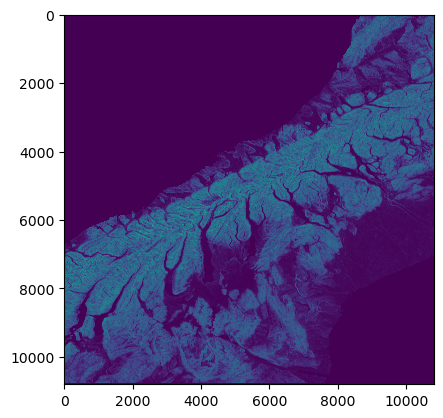

In [16]:
with rasterio.open(slope_path, "r") as src:
    array = src.read()[0, ...]
    plt.imshow(array, vmin=0, vmax=90)

### Creating a data stack

In [ ]:
# reproject all to EPSG:4326
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/reproject.py {sentinel2_mosaic_path} 4326;
    python utils/geo/reproject.py {sentinel1_asc_mosaic_path} 4326;
    python utils/geo/reproject.py {sentinel1_desc_mosaic_path} 4326;
    python utils/geo/reproject.py {dem_mosaic_path} 4326;
    python utils/geo/reproject.py {slope_path} 4326
    '
""", shell=True)

In [ ]:
# stack all the bands
stack_path = os.path.join(data_folder, "raster", "NZ1", "stack.tif")
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/stack.py {stack_path} {sentinel2_mosaic_path} {sentinel1_asc_mosaic_path} {sentinel1_desc_mosaic_path} {dem_mosaic_path} {slope_path}
    '
""", shell=True)

In [ ]:
# rasterize the reference data
outlines_path = os.path.join(data_folder, "vector", "NZ1", "outlines.shp")
raster_outlines_path = os.path.join(data_folder, "raster", "NZ1", "outlines.tif")
subprocess.run(f"""
    bash -c '
    source ~/anaconda3/bin/activate;
    conda activate geodask;
    python utils/geo/burn.py {outlines_path} {raster_outlines_path} {stack_path}
    '
""", shell=True)

In [ ]:
with rasterio.open(raster_outlines_path, "r") as src:
    array = src.read()[0, ...]
    plt.imshow(array, vmin=0, vmax=1)

## Producing the final dataset
### Making the train/val/test split

In [17]:
# read region tiles
regions = os.listdir(os.path.join(data_folder, "vector"))
region_tiles = {}

for region in regions:
    tiles = geopandas.read_file(os.path.join(data_folder, "vector", region, "tiles.shp"))
    region_tiles[region] = tiles

In [18]:
# make the split
train_tiles = set()
val_tiles = set()
test_tiles = set()
random.seed(42)

for region in regions: 
    tiles = region_tiles[region]
    codenames = list(tiles["codename"])
    random.shuffle(codenames)
    
    n_tiles = len(codenames)
    train_tiles = train_tiles.union(codenames[:int(0.6 * n_tiles)])
    val_tiles = val_tiles.union(codenames[int(0.6 * n_tiles):int(0.8 * n_tiles)])
    test_tiles = test_tiles.union(codenames[int(0.8 * n_tiles):])

In [19]:
# test on intersections
train_tiles & val_tiles, train_tiles & test_tiles, val_tiles & test_tiles

(set(), set(), set())

In [20]:
# calculate subset sizes
len(train_tiles), len(val_tiles), len(test_tiles)

(234, 78, 80)

### Creating .hdf5 files for training

In [21]:
# calculate min, max values of features in dataset
n_features = 10
mins = np.full((n_features, ), np.inf)
maxs = np.full((n_features, ), -np.inf)

for region in regions:
    stack_path = os.path.join(data_folder, "raster", region, "stack.tif")
    with rasterio.open(stack_path, "r") as src:
        array = np.ma.masked_invalid(src.read())
        stack_mins, stack_maxs = np.min(array, axis=(1, 2)), np.max(array, axis=(1, 2))
        mins, maxs = np.minimum(mins, stack_mins), np.maximum(maxs, stack_maxs)
mins, maxs = np.array(mins), np.array(maxs)

In [22]:
mins, maxs

(array([-1.31226340e-02, -3.53316241e-03, -1.31922048e-02, -2.03687567e-02,
        -1.84741002e-02, -1.77842826e-02, -5.99991150e+01, -5.99998474e+01,
        -7.70000000e+01,  0.00000000e+00]),
 array([2.34229994e+00, 2.28180003e+00, 2.69519997e+00, 2.67560005e+00,
        1.83229995e+00, 1.91508412e+00, 3.82308075e+02, 3.82308075e+02,
        8.35000000e+03, 8.90729752e+01]))

In [23]:
# save min, max values to reuse them later
with open(os.path.join(data_folder, "mins_maxs.pickle"), "wb") as min_max_file:
    pickle.dump((mins, maxs), min_max_file)

In [24]:
# define constants and create subset files
patch_size = 384
n_classes = 2

train = h5py.File(os.path.join(data_folder, "train.hdf5"), "w")
val = h5py.File(os.path.join(data_folder, "val.hdf5"), "w")
test = h5py.File(os.path.join(data_folder, "test.hdf5"), "w")

In [25]:
# iterate over the tiles, crop the stacks and put the data into .hdf5
for region in tqdm(regions):
    tiles = region_tiles[region]
    stack_path = os.path.join(data_folder, "raster", region, "stack.tif")
    outlines_path = os.path.join(data_folder, "raster", region, "outlines.tif")
    stack = rasterio.open(stack_path, "r")
    outlines = rasterio.open(outlines_path, "r")
    
    for codename, geometry in zip(tiles["codename"], tiles["geometry"]):
        # choose subset
        subset = None
        if codename in train_tiles:
            subset = train
        if codename in val_tiles:
            subset = val
        if codename in test_tiles:
            subset = test
            
        # read rasters cropped to tile
        xmin, ymin, xmax, ymax = geometry.bounds
        window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, transform=stack.transform)
        stack_cropped = np.moveaxis(stack.read(window=window), 0, -1)
        outlines_cropped = np.array(outlines.read(window=window)[0, ...])
        
        # normalize and curate features
        stack_cropped = (stack_cropped - mins) / (maxs - mins)
        stack_cropped[np.isnan(stack_cropped)] = 0
        stack_cropped[np.isinf(stack_cropped)] = 0
        
        # convert outlines into one-hot encoded vectors
        height, width = outlines_cropped.shape
        outlines_onehot = np.zeros((height, width, n_classes))
        for class_idx in range(n_classes):
            outlines_onehot[outlines_cropped == class_idx, class_idx] = 1
        
        # pad features and outlines to fit patch size
        new_height = (height // patch_size + 1) * patch_size
        new_width = (width // patch_size + 1) * patch_size
        pad_height = (new_height - height) // 2
        pad_width = (new_width - width) // 2
        stack_cropped_pad = np.zeros((new_height, new_width, n_features))
        outlines_onehot_pad = np.zeros((new_height, new_width, n_classes))
        stack_cropped_pad[pad_height:pad_height + height, pad_width:pad_width + width, :] = stack_cropped
        outlines_onehot_pad[:, :, 0] = 1 # padding stripes are background
        outlines_onehot_pad[pad_height:pad_height + height, pad_width:pad_width + width, :] = outlines_onehot
        
        # write data to file
        group = subset.create_group(codename)
        group.create_dataset("features", data=stack_cropped_pad)
        group.create_dataset("outlines", data=outlines_onehot_pad, dtype=np.uint8)
        group.attrs["pad_height"] = pad_height
        group.attrs["pad_width"] = pad_width
        group.attrs["height"] = height
        group.attrs["width"] = width
        group.attrs["xmin"] = xmin
        group.attrs["ymin"] = ymin
        group.attrs["xmax"] = xmax
        group.attrs["ymax"] = ymax
        
    stack.close()
    outlines.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [04:12<00:00, 50.48s/it]


In [26]:
# close subset files
train.close()
val.close()
test.close()